In [1]:
import pandas as pd

In [2]:
X = pd.DataFrame(
    {
        'city':['tokyo', None, 'london', 'seattle', 'sanfrancisco', 'tokyo'],
        'boolean':['yes', 'no', None, 'no', 'no', 'yes'],
        'ordinal_column':['somewhat like', 'like', 'somewhat like', 'like', 'somewhat like', 'dislike'],
        'quantitative_column':[1, 11, -.5, 10, None, 20]
    }
)
print(X)

           city boolean ordinal_column  quantitative_column
0         tokyo     yes  somewhat like                  1.0
1          None      no           like                 11.0
2        london    None  somewhat like                 -0.5
3       seattle      no           like                 10.0
4  sanfrancisco      no  somewhat like                  NaN
5         tokyo     yes        dislike                 20.0


In [3]:
X.isnull().sum()

city                   1
boolean                1
ordinal_column         0
quantitative_column    1
dtype: int64

In [4]:
from sklearn.base import TransformerMixin
class CustomCategoryImputer(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        
    def transform(self, df):
        X = df.copy()
        for col in self.cols:
            X[col].fillna(X[col].value_counts().index[0], inplace=True)
        return X
    
    def fit(self, *_):
        return self

In [5]:
cci = CustomCategoryImputer(cols=['city', 'boolean'])
cci.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,tokyo,no,like,11.0
2,london,no,somewhat like,-0.5
3,seattle,no,like,10.0
4,sanfrancisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


In [6]:
from sklearn.impute import SimpleImputer
class CustomQuantitativeImputer(TransformerMixin):
    def __init__(self, cols=None, strategy='mean'):
        self.cols = cols
        self.strategy = strategy
        
    def transform(self, df):
        X = df.copy()
        impute = SimpleImputer(strategy=self.strategy)
        for col in self.cols:
            X[col] = impute.fit_transform(X[[col]])
        return X
    
    def fit(self, *_):
        return self

In [7]:
cqi = CustomQuantitativeImputer(cols=['quantitative_column'], strategy='mean')
cqi.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,sanfrancisco,no,somewhat like,8.3
5,tokyo,yes,dislike,20.0


In [8]:
from sklearn.pipeline import Pipeline

In [9]:
imputer = Pipeline([('quant', cqi), ('category', cci)])
imputer.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,tokyo,no,like,11.0
2,london,no,somewhat like,-0.5
3,seattle,no,like,10.0
4,sanfrancisco,no,somewhat like,8.3
5,tokyo,yes,dislike,20.0


In [10]:
pd.get_dummies(X,
               columns=['city', 'boolean'],
               prefix_sep='__')

,ordinal_column,quantitative_column,city__london,city__sanfrancisco,city__seattle,city__tokyo,boolean__no,boolean__yes
0,somewhat like,1.0,0,0,0,1,0,1
1,like,11.0,0,0,0,0,1,0
2,somewhat like,-0.5,1,0,0,0,0,0
3,like,10.0,0,0,1,0,1,0
4,somewhat like,NaN,0,1,0,0,1,0
5,dislike,20.0,0,0,0,1,0,1


In [11]:
X

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,sanfrancisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


In [12]:
class CustomDummifier(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        
    def transform(self, X):
        return pd.get_dummies(X, columns=self.cols)
    
    def fit(self, *_):
        return self

In [13]:
cd = CustomDummifier(cols=['boolean', 'city'])
cd.fit_transform(X)

,ordinal_column,quantitative_column,boolean_no,boolean_yes,city_london,city_sanfrancisco,city_seattle,city_tokyo
0,somewhat like,1.0,0,1,0,0,0,1
1,like,11.0,1,0,0,0,0,0
2,somewhat like,-0.5,0,0,1,0,0,0
3,like,10.0,1,0,0,0,1,0
4,somewhat like,NaN,1,0,0,1,0,0
5,dislike,20.0,0,1,0,0,0,1


In [14]:
ordering = ['dislike', 'somewhat like', 'like']

In [15]:
print(X['ordinal_column'])

0    somewhat like
1             like
2    somewhat like
3             like
4    somewhat like
5          dislike
Name: ordinal_column, dtype: object


In [16]:
print(X['ordinal_column'].map(lambda value: ordering.index(value)))

0    1
1    2
2    1
3    2
4    1
5    0
Name: ordinal_column, dtype: int64


In [17]:
class CustomEncoder(TransformerMixin):
    def __init__(self, col, ordering=None):
        self.ordering = ordering
        self.col = col
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = X[self.col].map(lambda value: self.ordering.index(value))
        return X
    
    def fit(self, *_):
        return self

In [18]:
ce = CustomEncoder(col='ordinal_column', ordering=['dislike', 'somewhat like', 'like'])
ce.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,1,1.0
1,None,no,2,11.0
2,london,None,1,-0.5
3,seattle,no,2,10.0
4,sanfrancisco,no,1,NaN
5,tokyo,yes,0,20.0


# Bucketing continuous features into categories

In [19]:
pd.cut(X['quantitative_column'], bins=3)

0     (-0.52, 6.333]
1    (6.333, 13.167]
2     (-0.52, 6.333]
3    (6.333, 13.167]
4                NaN
5     (13.167, 20.0]
Name: quantitative_column, dtype: category
Categories (3, interval[float64, right]): [(-0.52, 6.333] < (6.333, 13.167] < (13.167, 20.0]]

In [20]:
pd.cut(X['quantitative_column'], bins=3, labels=False)

0    0.0
1    1.0
2    0.0
3    1.0
4    NaN
5    2.0
Name: quantitative_column, dtype: float64

In [21]:
class CustomCutter(TransformerMixin):
    def __init__(self, col, bins, labels=False):
        self.col = col
        self.bins = bins
        self.labels = labels

    def transform(self, df):
        X = df.copy()
        X[self.col] = pd.cut(X[self.col], bins=self.bins, labels=self.labels)
        return X

    def fit(self, *_):
        return self

In [22]:
cc = CustomCutter(col='quantitative_column', bins=3)
cc.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,0.0
1,None,no,like,1.0
2,london,None,somewhat like,0.0
3,seattle,no,like,1.0
4,sanfrancisco,no,somewhat like,NaN
5,tokyo,yes,dislike,2.0


In [23]:
from sklearn.pipeline import Pipeline

In [24]:
pipe = Pipeline([('imputer', imputer), ('dummify', cd), ('encode', ce), ('cut', cc)])

In [25]:
print(X)

           city boolean ordinal_column  quantitative_column
0         tokyo     yes  somewhat like                  1.0
1          None      no           like                 11.0
2        london    None  somewhat like                 -0.5
3       seattle      no           like                 10.0
4  sanfrancisco      no  somewhat like                  NaN
5         tokyo     yes        dislike                 20.0


In [26]:
pipe.fit(X)

Pipeline(steps=[('imputer',
                 Pipeline(steps=[('quant',
                                  <__main__.CustomQuantitativeImputer object at 0x00000174FFE19AC0>),
                                 ('category',
                                  <__main__.CustomCategoryImputer object at 0x00000174F0C83070>)])),
                ('dummify',
                 <__main__.CustomDummifier object at 0x00000174812A3AC0>),
                ('encode',
                 <__main__.CustomEncoder object at 0x00000174812AF850>),
                ('cut', <__main__.CustomCutter object at 0x00000174812C37F0>)])

In [27]:
pipe.transform(X)

,ordinal_column,quantitative_column,boolean_no,boolean_yes,city_london,city_sanfrancisco,city_seattle,city_tokyo
0,1,0,0,1,0,0,0,1
1,2,1,1,0,0,0,0,1
2,1,0,1,0,1,0,0,0
3,2,1,1,0,0,0,1,0
4,1,1,1,0,0,1,0,0
5,0,2,0,1,0,0,0,1


# Extending numerical features

## Activity recognition from the Single Chest-Mounted Accelerometer dataset

In [28]:
columns = ['index', 'x', 'y', 'z', 'activity']
df = pd.read_csv('1.csv', header=None)
df.columns = columns

In [29]:
df.head()

,index,x,y,z,activity
0,0.0,1502,2215,2153,1
1,1.0,1667,2072,2047,1
2,2.0,1611,1957,1906,1
3,3.0,1601,1939,1831,1
4,4.0,1643,1965,1879,1


In [30]:
# Let's determine the null accuracy to beat in our machine learning model.
df['activity'].value_counts(normalize=True)

7    0.515369
1    0.207242
4    0.165291
3    0.068793
5    0.019637
6    0.017951
2    0.005711
0    0.000006
Name: activity, dtype: float64

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [33]:
X = df[['x', 'y','z']]
y = df['activity']

In [34]:
knn_params = {'n_neighbors': [3, 4, 5, 6]}

In [50]:
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, knn_params)
grid.fit(X, y)

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 4, 5, 6]})

In [48]:
print(grid.best_score_, grid.best_params_)

0.7357680039194061 {'n_neighbors': 5}


In [51]:
from sklearn.preprocessing import PolynomialFeatures

In [61]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
# numpy
X_poly = poly.fit_transform(X)
X_poly.shape

(162501, 9)

In [60]:
pd.DataFrame(poly.fit_transform(X), columns=poly.get_feature_names_out()).head()

,1,x,y,z,x^2,x y,x z,y^2,y z,z^2
0,1.0,1502.0,2215.0,2153.0,2256004.0,3326930.0,3233806.0,4906225.0,4768895.0,4635409.0
1,1.0,1667.0,2072.0,2047.0,2778889.0,3454024.0,3412349.0,4293184.0,4241384.0,4190209.0
2,1.0,1611.0,1957.0,1906.0,2595321.0,3152727.0,3070566.0,3829849.0,3730042.0,3632836.0
3,1.0,1601.0,1939.0,1831.0,2563201.0,3104339.0,2931431.0,3759721.0,3550309.0,3352561.0
4,1.0,1643.0,1965.0,1879.0,2699449.0,3228495.0,3087197.0,3861225.0,3692235.0,3530641.0


In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

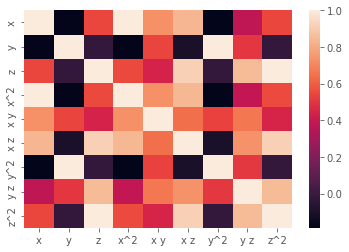

In [70]:
sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names_out()).corr())
plt.show()

In [72]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
# numpy
X_poly = poly.fit_transform(X)
X_poly.shape

(162501, 6)

In [73]:
pd.DataFrame(poly.fit_transform(X), columns=poly.get_feature_names_out()).head()

,x,y,z,x y,x z,y z
0,1502.0,2215.0,2153.0,3326930.0,3233806.0,4768895.0
1,1667.0,2072.0,2047.0,3454024.0,3412349.0,4241384.0
2,1611.0,1957.0,1906.0,3152727.0,3070566.0,3730042.0
3,1601.0,1939.0,1831.0,3104339.0,2931431.0,3550309.0
4,1643.0,1965.0,1879.0,3228495.0,3087197.0,3692235.0


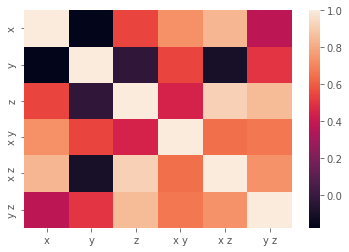

In [74]:
sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names_out()).corr())
plt.show()

In [88]:
pipe_params = {'poly_features__degree': [1, 2, 3], 'poly_features__interaction_only': [True, False], 'classify__n_neighbors': [3, 4, 5, 6]}

In [89]:
pipe = Pipeline([('poly_features', poly), ('classify', knn)])
grid = GridSearchCV(pipe, pipe_params)
grid.fit(X, y)

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "D:\Anaconda\lib\site-packages\sklearn\metrics\_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "D:\Anaconda\lib\site-packages\sklearn\pipeline.py", line 699, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
  File "D:\Anaconda\lib\site-packages\sklearn\base.py", line 666, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "D:\Ana

D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "D:\Anaconda\lib\site-packages\sklearn\metrics\_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "D:\Anaconda\lib\site-packages\sklearn\pipeline.py", line 699, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
  File "D:\Anaconda\lib\site-packages\sklearn\base.py", line 666, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py", line 219, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "D:\Anaconda\lib\site-packages\s

D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "D:\Anaconda\lib\site-packages\sklearn\metrics\_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "D:\Anaconda\lib\site-packages\sklearn\pipeline.py", line 699, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
  File "D:\Anaconda\lib\site-packages\sklearn\base.py", line 666, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py", line 219, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "D:\Anaconda\lib\site-packages\s

D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "D:\Anaconda\lib\site-packages\sklearn\metrics\_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "D:\Anaconda\lib\site-packages\sklearn\pipeline.py", line 699, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
  File "D:\Anaconda\lib\site-packages\sklearn\base.py", line 666, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py", line 219, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "D:\Anaconda\lib\site-packages\s

D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "D:\Anaconda\lib\site-packages\sklearn\metrics\_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "D:\Anaconda\lib\site-packages\sklearn\pipeline.py", line 699, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
  File "D:\Anaconda\lib\site-packages\sklearn\base.py", line 666, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py", line 219, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "D:\Anaconda\lib\site-packages\s

GridSearchCV(estimator=Pipeline(steps=[('poly_features',
                                        PolynomialFeatures(include_bias=False,
                                                           interaction_only=True)),
                                       ('classify', KNeighborsClassifier())]),
             param_grid={'classify__n_neighbors': [3, 4, 5, 6],
                         'poly_features__degree': [1, 2, 3],
                         'poly_features__interaction_only': [True, False]})

In [90]:
print(grid.best_score_, grid.best_params_)

0.7395217705490719 {'classify__n_neighbors': 5, 'poly_features__degree': 2, 'poly_features__interaction_only': True}


# Text-specific feature construction

In [95]:
tweets = pd.read_csv('twitter_sentiment.csv', encoding='latin1')
tweets.head()
del tweets['ItemID']

In [96]:
from sklearn.feature_extraction.text import CountVectorizer

In [97]:
X = tweets['SentimentText']
y = tweets['Sentiment']